### 02477 Bayesian Machine Learning - Exercise 6 

**Overview** 

The topic of this exercise is **multi-class classification** and **decision theory**. Probability theory and Bayes' rule tell us how to summarize our knowledge about a parameter or a prediction using probability distributions.  However, often we have to reduce these distributions a single decision, e.g. does the patient have cancer or not, and decision theory tells us how to do that in a principled manner. We will see how the **posterior predictive probabilities** play a key role in making **optimal decisions** and see how the choice of **utility function** affects the resulting decisions. We will also look at how to quantify and represent the predictive uncertainty for multiclass classification and how to investigate the accuracy of the posterior predictive probabilities.

We will study these concepts using **Bayesian linear models** for multi-class classification problems.

The exercise is divided into four parts:

- Part 1: Warm up: Linear models for multi-class classification


- Part 2: Bayesian decision theory for classification


- Part 3: Image classification


- Part 4: Calibration


Note that the in this exercise, we will need the python package called **PIL** for manipulating images. 


In [2]:
%matplotlib inline
import autograd.numpy as np
import pylab as plt
import seaborn as snb

from scipy.optimize import minimize
from autograd import value_and_grad

# for plotting
from matplotlib.colors import ListedColormap

# for manipulating images
from PIL import Image

from exercise6 import PCA_dim_reduction
from exercise6 import visualize_utility
from exercise6 import to_onehot
from exercise6 import BayesianLinearSoftmax

# style stuff
snb.set(font_scale=1.5)
snb.set_style('darkgrid')
colors = ['r', 'g', 'b', 'y'] 


### Part1: Bayesian linear models for multi-class classification 

In exericse 3 we used a logistic regression model for binary classification and in this exercise, we will work with the natural extension for multi-class classification.

Consider a multi-class dataset with $K$  classes and let $\mathcal{D} = \left\lbrace \mathbf{x}_i, t_i \right\rbrace_{i=1}^N$ denote a dataset, where $\mathbf{x}_i \in \mathbb{R}^D$ and $t_n \in \left\lbrace 1, 2, \dots, K\right\rbrace$ are the input feature and target label, respectively, for the $i$'th example.

As likelihood, we will use a categorical distribution

\begin{align*}
t_n|\mathbf{y}_n &\sim \text{Categorical}\left[\text{softmax}(\mathbf{y}_n)\right], \tag{1} \\
\end{align*}

which specifies the probability of observing each class given a set of latent function values ${\mathbf{y}_n} \in \mathbb{R}^K$ for $\mathbf{x}_n$. The latent function values are modeled using linear functions:

\begin{align*}
[\mathbf{y}_n]_i &= \mathbf{w}_i^T \phi(\mathbf{x}_n) \tag{2}\\
\mathbf{w}_i &\sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

for $i = 1, \dots, K$. The vector $\mathbf{y}_n \in \mathbb{R}^K$ in eq. (2) contains the values of the latent linear functions for all $K$ classes, i.e. $\mathbf{y}_n = \left[y^1(\mathbf{x}_n), y^2(\mathbf{x}_n), \dots, y^K(\mathbf{x}_n)\right]$, where the $i$'th function is represented using the vector $\mathbf{w}_i$. We use isotropic Gaussian priors for all the parameters of the models.

We will again resort to the Laplace approximation for inference because the posterior distribution is analytically intractable and use **Monte Carlo** sampling to estimate the posterior predictive probabilities.

**Note:** In the code we will represent the class labels as integers from $0, 1, \dots, K-1$ rather than from $1, \dots, K$ because Python counts from 0.

We will start with a small toy example with $K = 4$ classes. 

Text(0.5, 1.0, 'Posterior class probabilities $p(t=i|x)$')

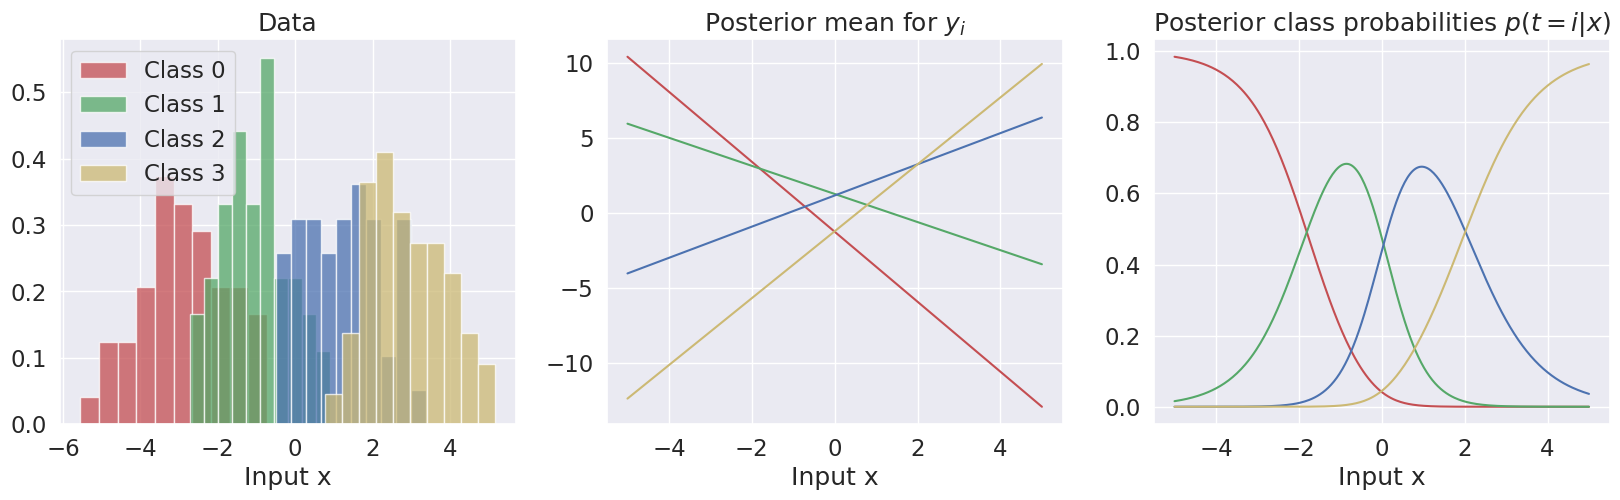

In [3]:
np.random.seed(0)

# number of data points per class
M = 50

# generate simple synthetic toy dataset
xi = [np.random.normal(-3, 1, size=(M, 1)),
      np.random.normal(-1, 1, size=(M, 1)),
      np.random.normal(1, 1, size=(M, 1)),
      np.random.normal(3, 1, size=(M, 1))]
x = np.row_stack((xi))
t = np.hstack((np.zeros(M), np.ones(M), 2*np.ones(M), 3*np.ones(M)))
num_classes = 4

# specify input points for predictions
xpred = np.linspace(-5, 5, 300)

# include intercept
design_matrix = lambda x: np.column_stack((np.ones(len(x)), x))

# fit model and compute predictions
bls = BayesianLinearSoftmax(design_matrix(x), t)
mu_y, var_y = bls.compute_posterior_y(design_matrix(xpred))
phat = bls.compute_predictive_prob(design_matrix(xpred))

# plot
fig, axes = plt.subplots(1,3, figsize=(20, 5))
for i in range(4):
    # plot histogram of data
    axes[0].hist(xi[i], density=True, label='Class %d' % i, alpha=0.75, color=colors[i]);
    # plot posterior mean of latent function y for each class
    axes[1].plot(xpred, mu_y[:, i], label='i = %d' % i, color=colors[i])    
    # plot posterior class probabilitites
    axes[2].plot(xpred, phat[:, i], label='i = %d' % i, color=colors[i])
    
axes[0].legend()
for i in range(3):
    axes[i].set_xlabel('Input x')
    
axes[0].set_title('Data')
axes[1].set_title('Posterior mean for $y_i$')
axes[2].set_title('Posterior class probabilities $p(t=i|x)$') 



**Questions**

1.1) Explain the role of the softmax-function in eq. (1) above and use the figures above to explain why the name "softmax" makes sense
* The softmax function transforms each entry in $\textbf{y}_n$ to be a vector of length = #classes containing the probabilities for each class for the given sample i.e. the vector sums to 1
* It is named "softmax" because it is a smoothned version of the max function i.e. differentiable.

1.2) Implement and plot the **confidence** and **entropy** for the predictive distributions above for each value of $x$ in the vector *xpred* (similar to the rightmost plot above). Comment on the relation between the confidence and entropy plots and the posterior predictive probabilities.



In [5]:
### solution for 1.2
def entropy(p):
    """ assumes p is [N, K] where N is the number of prediction points and K is the number of classes """
    return - np.sum(p*np.log(p), axis=1)

def confidence(p):
    """ assumes p is [N, K] where N is the number of prediction points and K is the number of classes """
    return np.max(p, axis=1) 

Text(0.5, 1.0, 'Confidence')

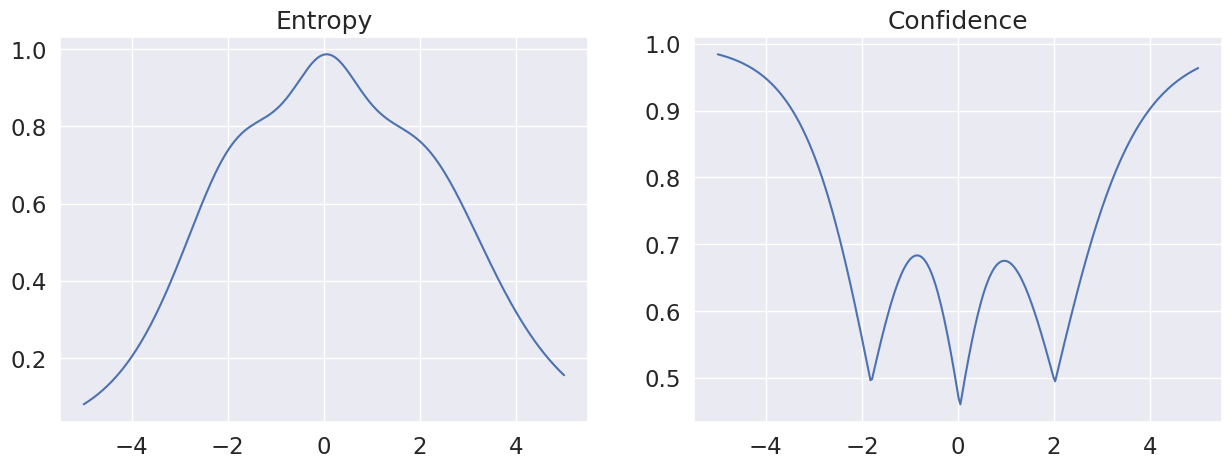

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(xpred, entropy(phat))
ax[0].set_title("Entropy")
ax[1].plot(xpred, confidence(phat))
ax[1].set_title("Confidence") 

### Part 2: Bayesian decision theory for classification 

Making a decision for multi-class classification entails assigning a class label $\hat{t} \in \left\lbrace 1, 2, \dots, K\right\rbrace$ to a new test point $\mathbf{x}_*$. In Bayesian decision theory, the utility function $\mathcal{U}(t_*, \hat{t})$ specifies the **utility** (i.e. gain) for predicting $\hat{t}$ when the true target is $t_*$.

In practice, we don't know the true target $t_*$, but the predictive posterior distribution $p(t_*|\mathbf{t}, \mathbf{x}_*)$ contains all the relevant knowledge about $t_*$ given our data observed $\mathbf{t}$. Therefore, we compute the **expected utility** wrt. the posterior predictive distribution for each possible value of $\hat{t}$ and then assign the class label that **maximizes the expected utility**. That is,

\begin{align*}
\hat{t} = \arg\max\limits_{i \in \left\lbrace 1, 2, \dots, K\right\rbrace} \mathbb{E}_{p(t_*|\mathbf{t}, \mathbf{x}_*)}\left[\mathcal{U}(t_*, \hat{t}=i)\right]
\end{align*}

In the lecture we saw that in order to make optimal decisions under the **0/1-utility function** (remember utility is just negative loss and vice versa), we simply have to pick the class label with largest posterior probability. Let's investigate this empirically and study how the decision regions change when we change the utility-function. 

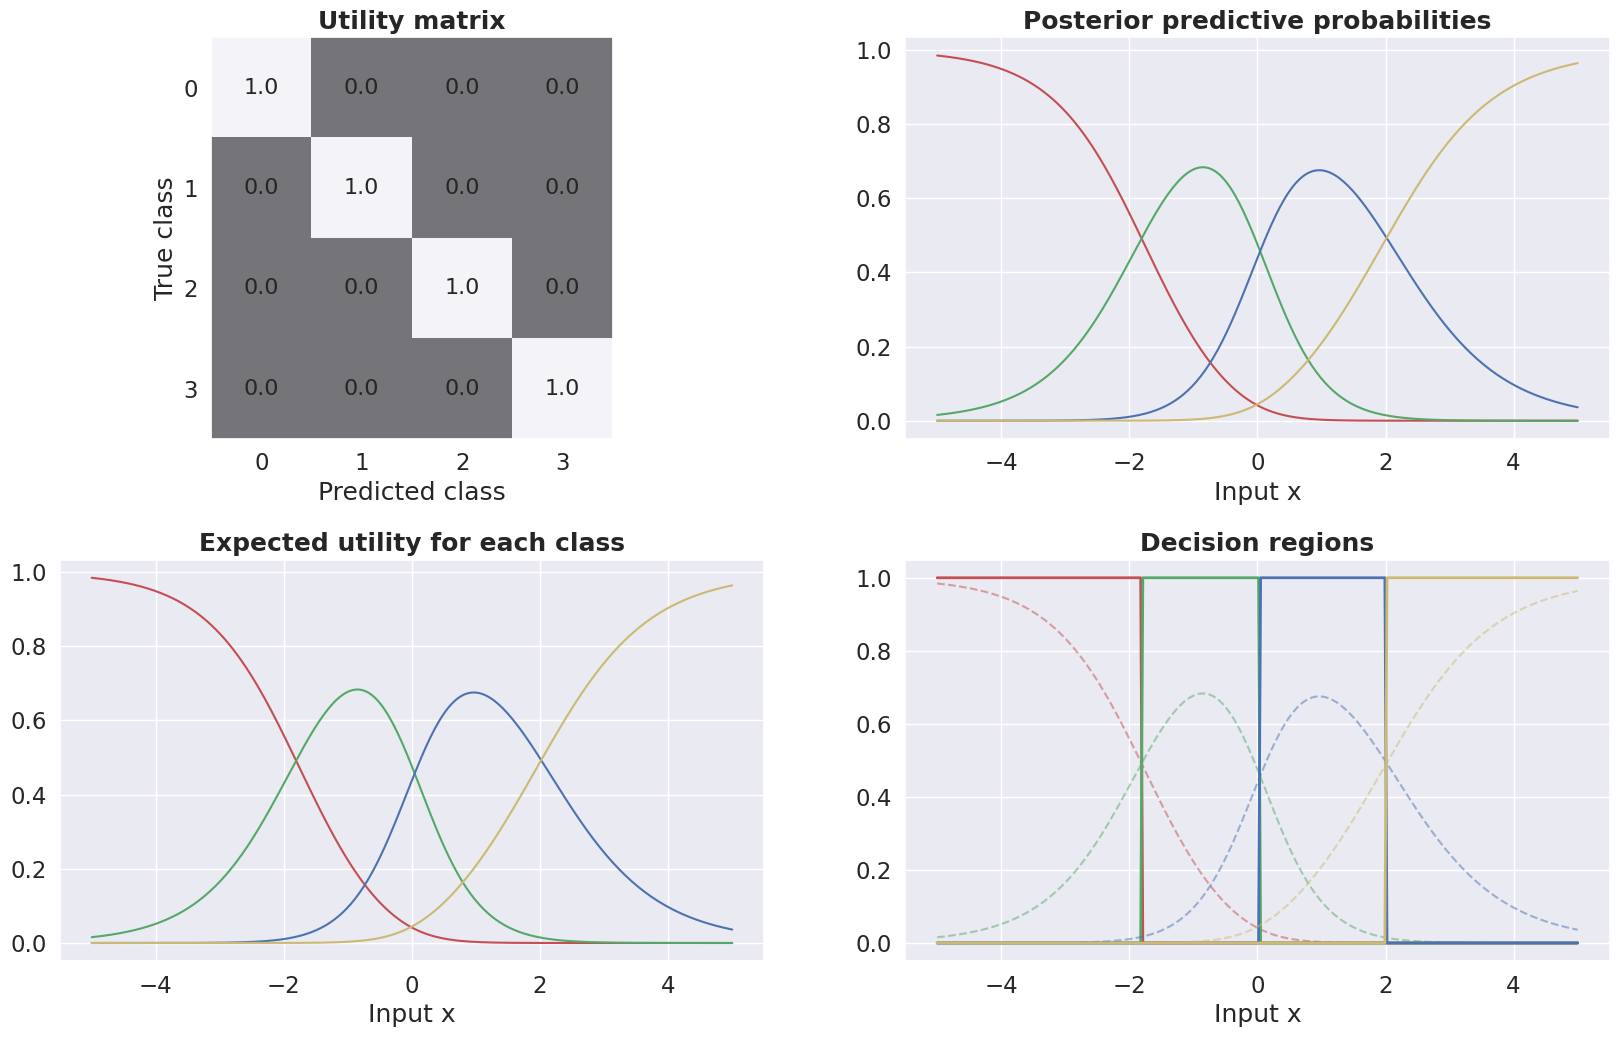

In [7]:
# define utility matrix
U = np.identity(num_classes)

# compute the expected utility for each class
expected_utility = phat@U

# make decisions
decisions = to_onehot(np.argmax(expected_utility, axis=1), num_classes)
    
# plot everything
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# utility matrix
visualize_utility(axes[0,0], U)

# posterior predictive probs
for i in range(num_classes):
    axes[0,1].plot(xpred, phat[:, i], color=colors[i])
axes[0,1].set_title('Posterior predictive probabilities', fontweight='bold')
axes[0,1].set_xlabel('Input x')

# expected utility
for i in range(num_classes):
    axes[1,0].plot(xpred, expected_utility[:, i], color=colors[i]);
axes[1,0].set_title('Expected utility for each class', fontweight='bold')
axes[1, 0].set_xlabel('Input x')

# decisions
for i in range(num_classes):
    axes[1,1].plot(xpred, decisions[:, i], color=colors[i], linewidth=2);
    axes[1,1].plot(xpred, phat[:, i], color=colors[i], alpha=0.5, linestyle='--')
axes[1,1].set_title('Decision regions', fontweight='bold')
axes[1,1].set_xlabel('Input x')

fig.subplots_adjust(hspace=0.3) 
    

**Questions**

2.1) Use the figure above to explain how Bayesian decision theory works for multi-class classification.
* Based on our posterior predictive probabilities we create the epected utility distributions and split them into selection regions where each region defines a prediction class that an input in the region will be classified as. The class for a region is the class with the highest expected utility in the at region i.e. the highest posterior predictive probability.

2.2) Explain how the expected utilities are calculated.
* We can ourselves define the utilities to e.g. put negative values on some kinds of wrong predictions e.g. to punish the model for predicting cancer patients to not have cancer.
* The expected utilities are then calculated as the sum of utility weights multiplied by the prediction probabilities. Then when we try to maximize the utility the model will fit in a way where it takes the correct predition of patients with cancer into greater considerant i.e. weight them.
* In this way the expected utility can be seen as a weighted average where we have control over the weights and can impose extra rewards or penalizations on the model for specific predictions.

2.3) What happens to the expected utilities and to the decisions if you scale the utility matrix by a positive constant?
* The expected utilities will be scaled by the factor
* The decision regions will remain the same i.e. the decisions will be the same for the class predictions

2.4) What happens to the decision boundary if you introduce a negative utility of $-1$ for predicting 1 (green), when the true target is 0 (red)? What about $-2$?
* The decision boundary for green will be narrower, as there now is a penalty for wrong predictions of green, and so the model needs to be more certain before it predicts green.

2.5) What happens if you change the 0/1 utility function to have $U_{23} = U_{32} = 1$?
* Then the yellow and blue are considered equally good choices, and the model can just optimize for one of them
* This is also what we see, where the utility distributions are plotted on top of each other and only one of the classes are used in the decision region while the other is neglected

2.6) What happens if you change the 0/1 utility function to have $U_{11} = 0$? or to $U_{11} = 0.5$?
* If we set it to 0 then the model gets no utility from predicting green, and so it simply removes the 'green' from the decisions
* If we set it to 0.5 then we reduce the expected utiltiy from 'green' predition, and so the decision region becomes more narrow, because the model needs a higher probability to predict green. 

### Part 3: Image classification

It's now time to apply the material from part 1 and part 2 to a real dataset. Specifically, we will work with a subset of the Linnaeus 5 dataset (http://chaladze.com/l5/). The original Linnaeus 5 dataset contains images of size 256x256 from 5 classes, but we will work with a subset of this dataset containing a total of 3200 images in 4 classes (dogs, birds, flowers, berries). The images have been resized to 128x128 with the sole purpose of reducing the size of the data file. 

We will use **transfer learning** and use a pretrained ResNet18-network as a **feature extractor** for the images. ResNet18 is a convolutional neural network with 18 layers, which has been trained on a huge image dataset called ImageNet. The ImageNet containes images from 1000 different classes, which means that the very last layer of the ResNet architecture is a softmax-layer with 1000 outputs. However, if we get rid of the very last layer, we can use the rest of the network as a general feature extractor for images. That is, we propagate each image through the network we can use the very last hidden layer as a 512-dimensional feature vector for the image.

The details of how this works beyond what's written above is **not** part of the curriculum of the course and therefore, we have pre-computed feature vectors for all the images for you. 

However, if you are interested in the details, you can look at the following resources:

- Code used for feature extraction [here](https://github.com/christiansafka/img2vec)
- Paper describing the ResNet architecture [here](https://arxiv.org/pdf/1512.03385.pdf)
- A Pytorch tutorial for transfer learning for vision problems [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)


Let's load the data 

In [8]:
data = np.load('./ex6_data.npz')
labels = list(data['labels'])
targets = data['targets']
num_classes = data['num_classes'][()]

Xtrain, Xtest = data['Xtrain'], data['Xtest']
ttrain, ttest = data['ttrain'], data['ttest']
train_idx = data['train_idx']
test_idx = data['test_idx']

N, D = Xtrain.shape
Ntest = len(Xtest)
print(f'Number of images for training: {N}')
print(f'Number of images for test: {Ntest}')
print(f'Number of features: {D}')
print(f'Number of clases: {num_classes}') 


Number of images for training: 320
Number of images for test: 2880
Number of features: 512
Number of clases: 4


.. and plot a few examples 

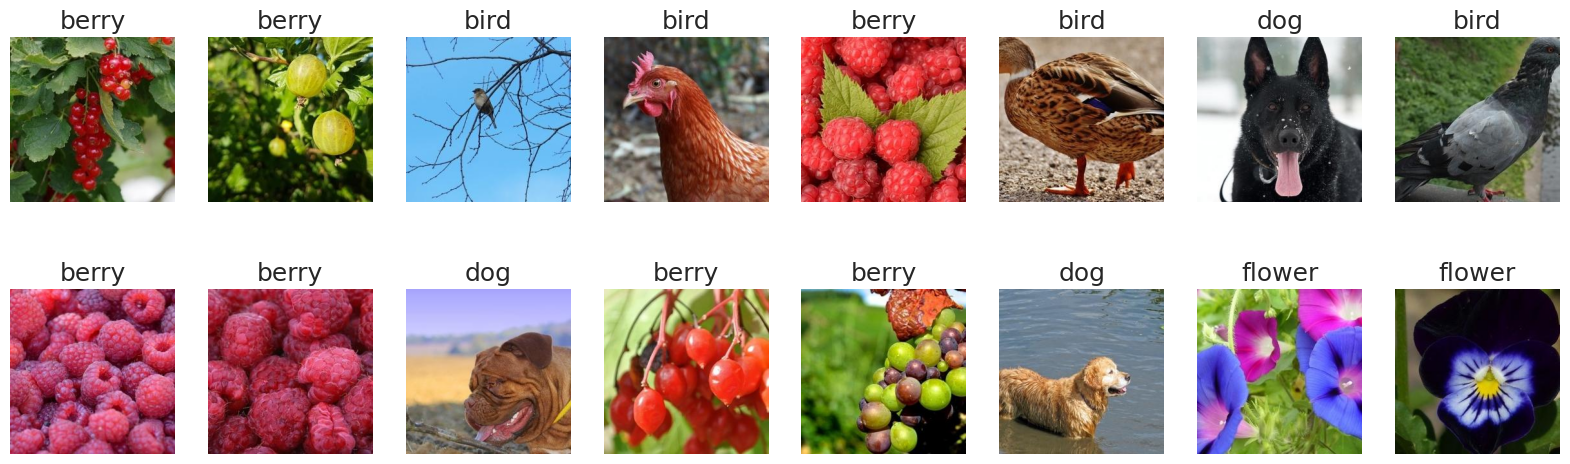

In [9]:
def show_example(ax, i):
    """ show training example i """
    
    j = train_idx[i]
    img = Image.open('./images/%d.jpg' % j)
    target = targets[j]
    ax.imshow(img)
    ax.set_title(labels[int(target)])
    ax.grid(False)
    ax.axis('off')

fig, ax = plt.subplots(2, 8, figsize=(20, 6))
for i in range(16):
    show_example(ax.flat[i], i) 

Each image is represented using a 512-dimensional feature vector, but we will (again) reduce the dimensionality to $D = 2$ using principal component analysis (PCA) for the purpose of visualization

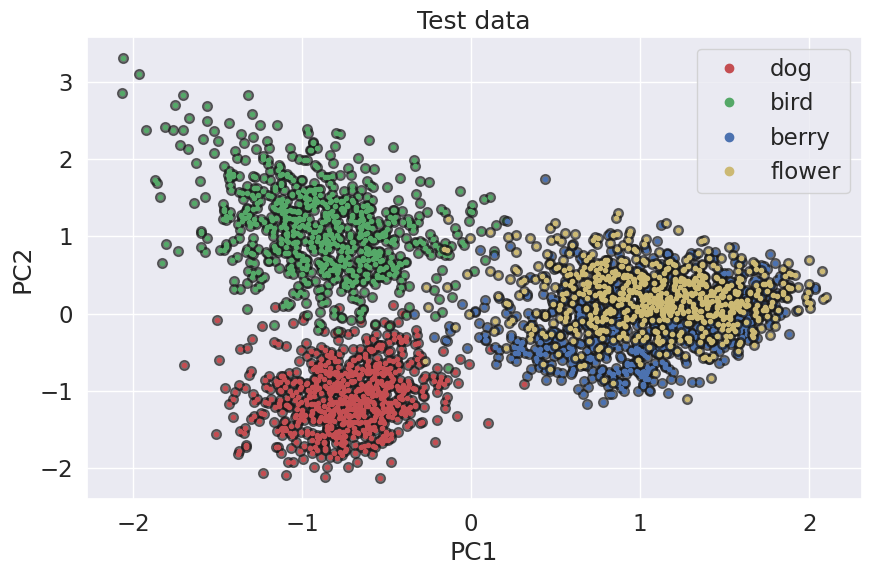

In [10]:
Ztrain, Ztest = PCA_dim_reduction(Xtrain, Xtest, num_components=2)

def plot_pca_data(ax, legend=True, alpha=1):

    for i in range(num_classes):
        ax.plot(Ztest[ttest==i, 0], Ztest[ttest==i, 1], '.', color='k', markersize=14, alpha=0.6)
        ax.plot(Ztest[ttest==i, 0], Ztest[ttest==i, 1], '.', color=colors[i], label=labels[i], markersize=6, alpha=alpha)
    if legend:
        ax.legend(markerscale=2)
    ax.set(xlabel='PC1', ylabel='PC2')
    ax.set_title('Test data')

fig, ax = plt.subplots(figsize=(10, 6))
plot_pca_data(ax); 


Let's  fit the model and visualize the posterior class probabilitites.

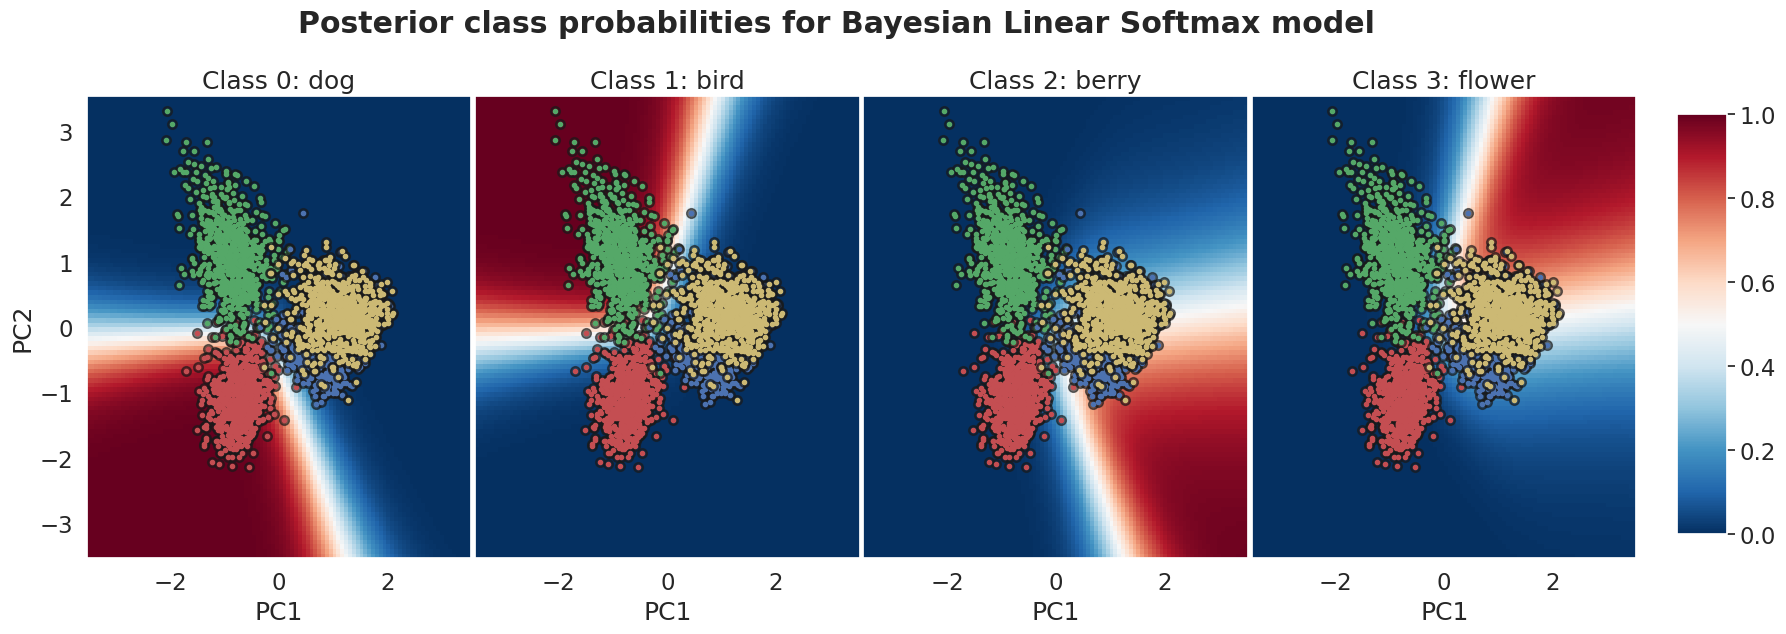

In [11]:
def visualize_regions(x_grid, posterior_class_probs, name, show_data=True):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
    for i in range(num_classes):
        
        probs_reshaped =  posterior_class_probs[:, i].reshape((len(x_grid), len(x_grid)))
        im = axes[i].pcolormesh(x_grid, x_grid,probs_reshaped, cmap=plt.cm.RdBu_r, clim=(0, 1), shading='auto')

        if show_data:
            plot_pca_data(axes[i], legend=False)
        axes[i].set_title('Class %d: %s' % (i, labels[i]))

        if i > 0:
            axes[i].set_yticklabels([])
            axes[i].set_ylabel('')

    fig.subplots_adjust(right=0.9, wspace=0.01)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
    fig.colorbar(im, cax=cbar_ax);
    fig.suptitle(name, fontweight='bold', y=1.025)
        
# we want to have an intercept in the model
Phi_train, Phi_test = design_matrix(Ztrain), design_matrix(Ztest)
 
# prepare grid for making predictions
x_grid = np.linspace(-3.5, 3.5, 100)
XX1, XX2 = np.meshgrid(x_grid, x_grid)
Xp = np.column_stack((XX1.ravel(), XX2.ravel()))
Phi_pred = design_matrix(Xp)

# Fit linear classifier
bls = BayesianLinearSoftmax(Phi_train, ttrain)
p_pred_bls = bls.compute_predictive_prob(Phi_pred)

# visualize the posterior class proabilities for each model
visualize_regions(x_grid, p_pred_bls, 'Posterior class probabilities for Bayesian Linear Softmax model') 

**Questions**
 
3.1) Compute predictions (wrt. the 0/1-utility function) and compute the accuracy for the training and test set.

3.2) Compute and plot the **entropy** and **confidence** for the predictions in the plot above. In which areas of the input space is this model most uncertain about the class label? 

3.3) Compute the compute the average confidence for the training set and test set and compare to the results from 3.1) 

### Making decisions with a reject option 

Next, we will investigate how to make decisions with a **reject** option, meaning we avoid to making any decisions if the confidence is below a specified threshold $p_{\text{reject}}$. 

Rejections for p_reject = 0.6: 10.37%


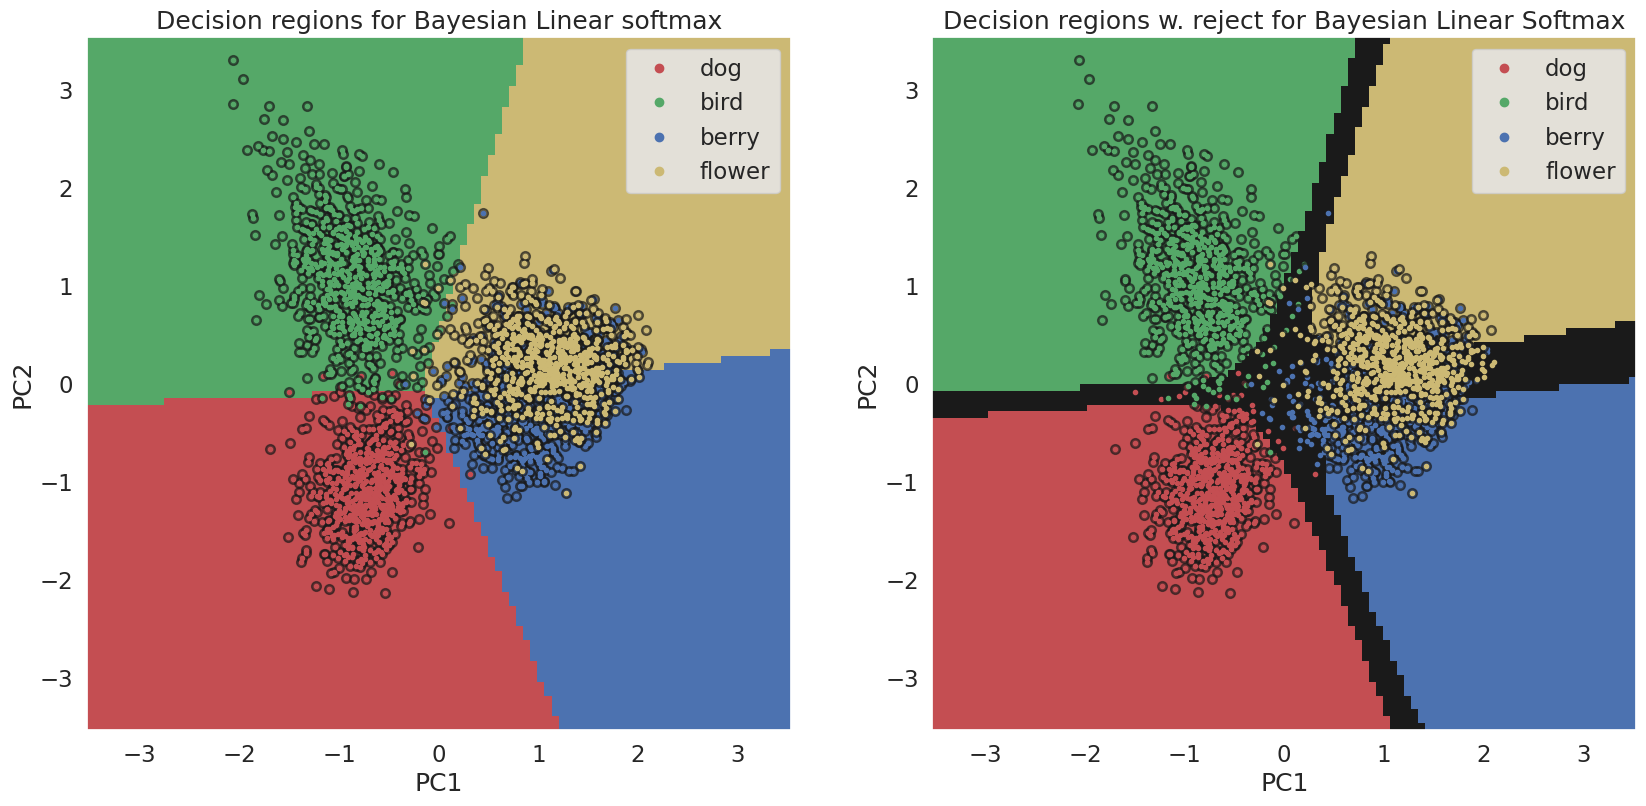

In [43]:
# specify reject threshold
p_reject = 0.6 # for value smaller than 0.2669 the whole red area in the lower left corner becomes black

# compute decisions under 0/1-utility function and reshape to grid
decisions_bls = np.argmax(p_pred_bls, axis=1).reshape((len(x_grid), len(x_grid)))

print(f'Rejections for p_reject = {p_reject}: {100*sum(p_pred_confidence < p_reject)/len(p_pred_confidence)}%')

# identify reject regions
p_pred_confidence = confidence(p_pred_bls)
reject_region_bls = 1.0*np.logical_not((p_pred_confidence < p_reject).reshape((len(x_grid), len(x_grid))))
decisions_bls_with_reject = (decisions_bls+1)*reject_region_bls

# visualize
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 9))
plot_pca_data(axes[0])
axes[0].pcolormesh(x_grid, x_grid, decisions_bls, cmap=ListedColormap(colors), alpha=1, shading='auto')
axes[0].set_title('Decision regions for Bayesian Linear softmax')
plot_pca_data(axes[1]);
axes[1].pcolormesh(x_grid, x_grid, decisions_bls_with_reject, cmap=ListedColormap(['k'] + colors), shading='auto')
axes[1].set_title('Decision regions w. reject for Bayesian Linear Softmax');
 


**Questions**

3.4) Explain what you see in the figure above - relate the **reject region** in black to the confidence plot in the figure from 3.2
* In the left plot we the Bayesian Linear Softmax model predictions with no rejections on the decision regions.
* On the right hand plot we see rejection regions added in black and they are added in the lowest confidens areas seen in 'white' in the plots of figure 3.2.
    * This makes sense as the decision boundaries are the areas with highest uncertainty for the model and so this is where we would like the model to express its lack of knowledge and reject a prediction (maybe to request help from a human expert) 

3.5) What happens to the reject region if you increase or decrease the reject threshold?
* If we increase the reject threshold then more of the model outputs/predictions will be included in the rejection regions i.e. wider black lines/areas
* The opposite will happen if the reject threshold is decreased


3.6) How many percent of the samples in the test set are rejected with $p_{\text{reject}} = 0.6$?
* 10.37%


3.7) What is the test accuracy rate for the samples in the test set, which are not rejected?

3.8) If we were to make a decision for the test samples in the reject region, what would the accuracy rate be? 


In [83]:
y_test = bls.compute_predictive_prob(Phi_test)
y_test_pred = np.argmax(y_test, axis=1)
y_test_confidence = np.max(y_test, axis=1)

In [93]:
rejected = list(y_test_confidence < p_reject)
accepted = np.logical_not(y_test_confidence < p_reject)

In [97]:
y_accept_acc = sum(y_test_pred[accepted] == ttest[accepted])/sum(accepted)
y_reject_acc = sum(y_test_pred[rejected] == ttest[rejected])/sum(rejected)
y_all_acc = sum(y_test_pred == ttest)/len(ttest)

print(f'Test accuracy for accepted predictions with p_reject = {p_reject}: {y_accept_acc:.2f}')
print(f'Test accuracy for rejected predictions with p_reject = {p_reject}: {y_reject_acc:.2f}')
print(f'Test accuracy for all predictions with no rejections: {y_all_acc:.2f}')

Test accuracy for accepted predictions with p_reject = 0.6: 0.89
Test accuracy for rejected predictions with p_reject = 0.6: 0.59
Test accuracy for all predictions with no rejections: 0.80



3.9) Instead, if the reject option, implement the following utility function and plot the corresponding decision boundaries:

- Utility of 1 for correctly classifying dogs, birds, and flowers
- Utility of 2 for correctly classifying berries
- Utility of 0 for all misclassifications



### Part 4: Calibration

As we have seen, the posterior predictive probabilities play a key role in decision making. In the last part of this exercise, we will study calibration of these probabilities. We will study the calibration of the individual posterior predictive class probabilities $p(t_*=i|\mathbf{t},\mathbf{x}^*)$ as follows:

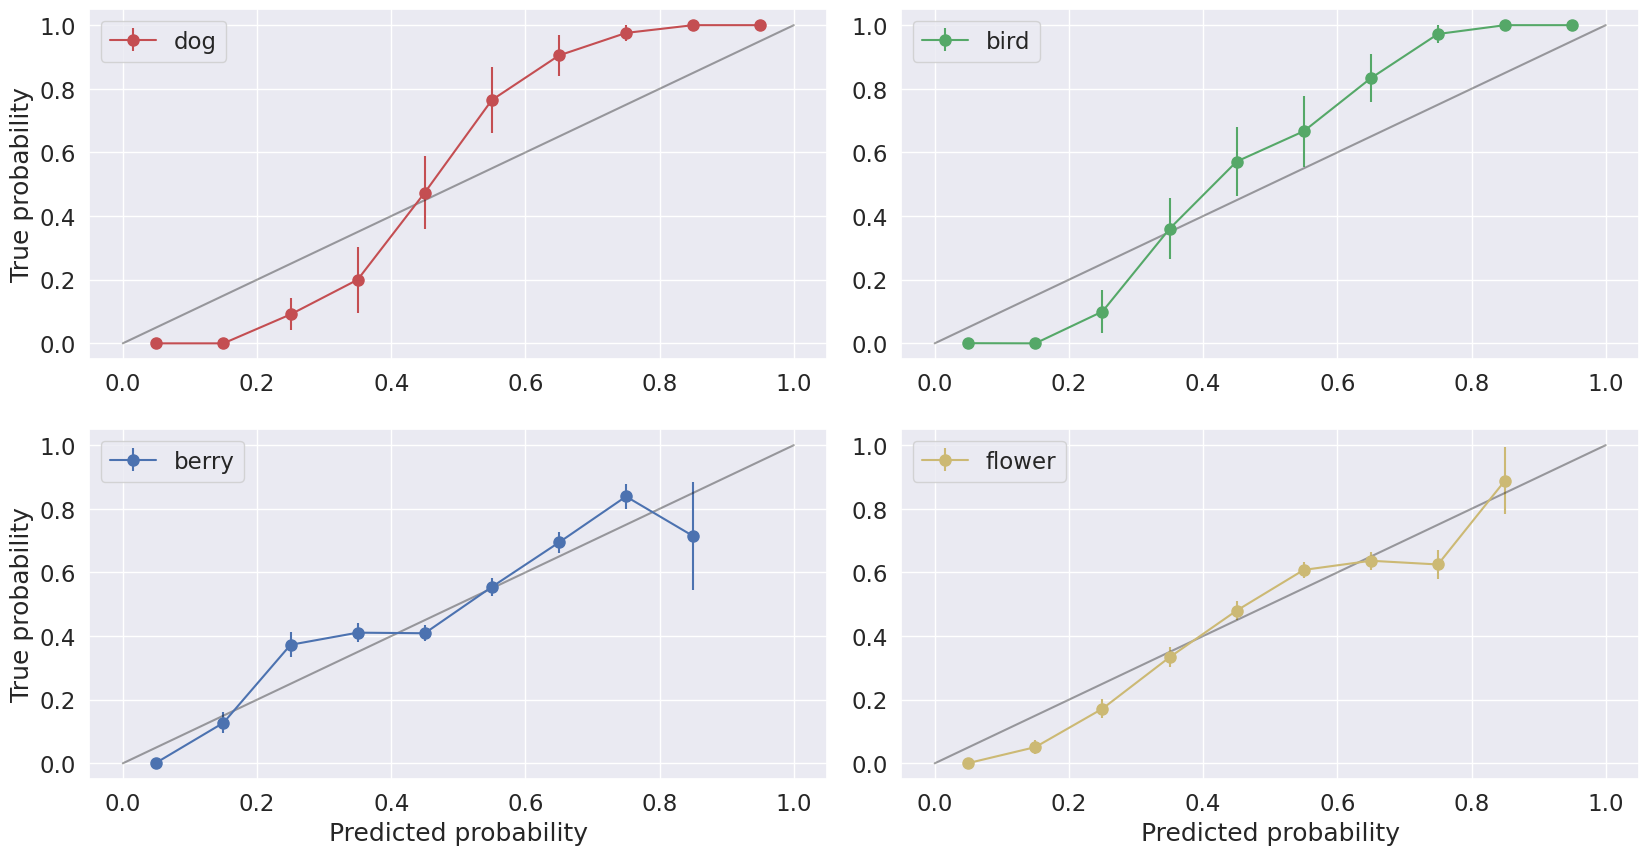

In [98]:
def compute_calibration_curve(targets, probs, num_bins=10):

    bins = np.linspace(0, 1, num_bins+1)

    p_true_mean, p_true_se, p_pred = [], [], []

    for i in range(num_bins):
        bin_start, bin_end = bins[i], bins[i+1]
        bin_center = 0.5*(bin_start + bin_end)
        
        bin_idx = np.logical_and(bin_start <= probs, probs < bin_end)
        num_points_in_bin = np.sum(bin_idx)
        
        if len(targets[bin_idx]) == 0:
            continue

        p_pred.append(bin_center)
        p_est = np.mean(targets[bin_idx])
        p_true_mean.append(p_est)
        p_true_se.append(np.sqrt(p_est*(1-p_est)/num_points_in_bin))
        
    return np.array(p_true_mean), np.array(p_true_se), np.array(p_pred)

p_test_bls = bls.compute_predictive_prob(Phi_test)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for class_idx in range(num_classes):
    ax = axes.flatten()[class_idx]
    p_true_mean, p_true_se, p_pred = compute_calibration_curve(ttest==class_idx, p_test_bls[:, class_idx])
    ax.errorbar(p_pred, p_true_mean, p_true_se, label=labels[class_idx], color=colors[class_idx], marker='o', markersize=8)
    ax.plot([0, 1], [0, 1], 'k-', alpha=0.4)
    ax.legend()
    

axes[1,0].set_xlabel('Predicted probability')
axes[1,1].set_xlabel('Predicted probability')
axes[0,0].set_ylabel('True probability')
axes[1,0].set_ylabel('True probability')


fig.subplots_adjust(wspace=0.1)


**Question**


4.1) Explain what see you in the figures above and how calibration curves are calculated
* We see the predicted probability from the original model mapped against the "true probability" based on the test sample statistics. What we would like to see for a well calibrated model is low variance in each 'bin point/dot' on the graph and that the graph follows the gray diagonal line. In that case the graph (created using samples from the test data) true probabilities matches those of the original model. Then the original model represents the test data probabilities perfectly and we don't need to calibrate it further.


4.2) Why do we need a fairly large test set to study calibration?
* The test set should be large enough to provide a representative sample of the population that the model is intended to generalize to. If the test set is too small, the estimates of calibration may be unreliable or unstable, particularly for rare events or subgroups within the data. This is because the small sample size can lead to high variability in the estimates of the true probabilities, which can make it difficult to distinguish between calibration errors and random noise.


4.3) Are all 4 class probabilities equally well/poorly calibrated?
* No the `berry` and `flower` class probabilities have the best calibrations i.e. they are close to the diagonal line even with high variance on the last points
* The `bird` and `dog` class probabilities shoots too high in the low probabilities and too low at the high probabilities and have high variance in the middle probabilties with the `dog` class probably being a little worse than the `bird` class


We can sometimes improve calibration by applying a post-hoc monotonic transformation. This simplest version is called **Platt scaling**. The idea is that we fit a logistic regression model to the **binary targets** using the **predicted class probabilities** as inputs. That is, we want to fit the following model

\begin{align*}
P(t_n=1|\mathbf{x}_n) = \frac{1}{1 + \exp(A  + B\cdot f(\mathbf{x}_n))},
\end{align*}

where $f(\mathbf{x}_n)$ denotes the predicted probability for $\mathbf{x}_n$. We fit the two scalar parameters $A$ and $B$ using maximum likelihood. 

That is, instead of using $f(\mathbf{x})$ as predictive probability for $\mathbf{x}^*$, we will use 

\begin{align*}
f_{\text{calibrated}}(\mathbf{x}^*) = \frac{1}{1 + \exp(\hat{A}_{ML}  + \hat{B}_{ML}\cdot f(\mathbf{x}^*))}
\end{align*}

Below is a simple implementation of Platt scaling:

Text(0, 0.5, 'True probability')

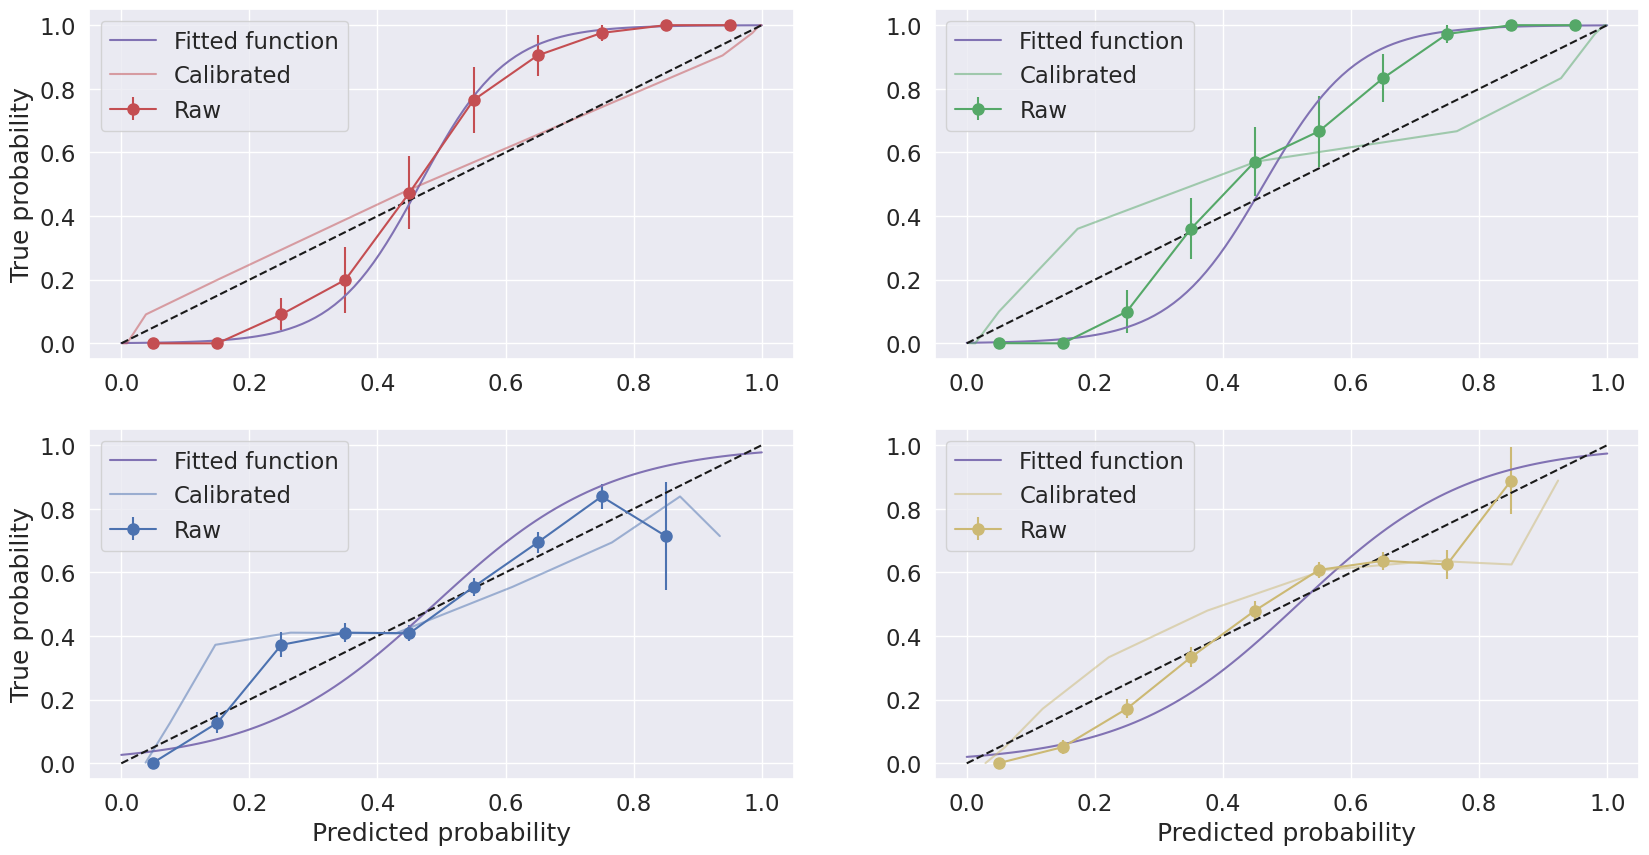

In [100]:
sigmoid = lambda x: 1./(1+ np.exp(-x))

class PlattCalibration(object):
    
    def __init__(self, t_binary, probs, num_bins=10):
        
        self.num_bins = num_bins
        self.t_binary = t_binary
        self.probs = probs
        self.fit()
    
    def fit(self):
        
        t_binary_scaled = np.array(self.t_binary)
        Nplus = np.sum(t_binary_scaled==1)
        Nminus = np.sum(t_binary_scaled==0)
    
        # John Platt advocates using smoothed target to avoid overfitting
        t_binary_scaled[self.t_binary==1] = (Nplus + 1)/(Nplus + 2)
        t_binary_scaled[self.t_binary==0] = 1/(Nminus + 2)
    
        # define log likelihood
        log_lik = lambda w: t_binary_scaled*np.log(self.calibrate(self.probs, w)) + (1-t_binary_scaled)*np.log(1-self.calibrate(self.probs, w))
    
        # optimize the negative log likelihood from above
        obj = lambda w: -np.sum(log_lik(w))
        res = minimize(value_and_grad(obj), np.zeros(2), jac=True)
        self.w = res.x
        
    def calibrate(self, p, w=None):
        if w is None:
            w = self.w
            
        return sigmoid(w[0] + w[1]*p)
        
        
ps = np.linspace(0, 1, 100)
                                
fix, axes = plt.subplots(2, 2, figsize=(20, 10))
for class_idx in range(num_classes):
    
    ax = axes.flatten()[class_idx]
    p_true_mean, p_true_se, p_pred = compute_calibration_curve(ttest==class_idx, p_test_bls[:, class_idx])
    
    # calibrate using Platt scaling
    platt = PlattCalibration(1.0*(ttest==class_idx), p_test_bls[:, class_idx])        
    p_pred_cal = platt.calibrate(p_pred)
        
    ax.errorbar(p_pred, p_true_mean, p_true_se, label="Raw", color=colors[class_idx], marker='o', markersize=8)
    ax.plot(ps, platt.calibrate(ps), color='m', label='Fitted function (Platt Scaling)')
    ax.plot(p_pred_cal, p_true_mean, label="Calibrated", color=colors[class_idx], linestyle='-', alpha=0.5)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.legend(loc='upper left')
    
axes[1,0].set_xlabel('Predicted probability')
axes[1,1].set_xlabel('Predicted probability')
axes[0,0].set_ylabel('True probability')
axes[1,0].set_ylabel('True probability')


**Questions**


4.4) Explain how Platt scaling works in your own words.
* Platt scaling works by training a new model in this example a logistic regression model on the output of our model and make the new model learn to output probabilities for the out put of the original model.
* Platt Scaling is a statistical technique used in machine learning to convert the output of a machine learning model into a probability score. In simple terms, it's a way to estimate the likelihood that a particular prediction made by a machine learning model is correct.
* The basic idea behind Platt Scaling is to train a separate "calibration" model on the output of the original machine learning model. This calibration model takes the output of the original model (which could be anything, depending on the type of machine learning model used) as its input and learns to produce a probability score between 0 and 1 as its output.

4.5) How well does Platt scaling work for each of the four classes?
* Funny enough the Platt scaling works best for the `dog` class which previously had the worst calibration. For the other classes it's a little more difficult to say how great of an improvement we see. From just look it seems that there is no improvement or even a worse calibration for the other classes.